In [1]:
import numpy as np
import pandas as pd
import os
import xarray as xr
import seaborn as sns

from n0_config_params import *
from n0bis_config_analysis_functions import *
from n0ter_stats import *

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


/home/jules/anaconda3/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
/home/jules/anaconda3/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.2, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


# LOAD DATA PARIS

In [2]:
sujet_list = np.array(['01PD','02MJ','03VN','04GB','05LV','06EF','07PB','08DM','09TA','10BH','11FA','12BD','13FP',
'14MD','15LG','16GM','17JR','18SE','19TM','20TY','21ZV','22DI','23LF','24TJ','25DF','26MN','27BD','28NT','29SC',
'30AR','31HJ','32CM','33MA']) #exclude PB07
session_list = np.array(['o', '+', '-'])
cond_list = np.array(['FR_CV_1', 'MECA', 'CO2', 'FR_CV_2'])

correspondance_odor = {'+' : 'P', 'o' : '0', '-' : 'N'}
correspondance_cond = {'FR_CV1' : 'Variables cycle BL', 'MECA' : 'Variables cycle T1', 'CO2' : 'Variables cycle T2', 'FR_CV2' : 'VS POST'}

df_columns_keep = ['TI', 'Te', 'Ttot', 'BF', 'VT', 'Ve', 'VT/Ti', 'Ti/Ttot', 'PRESS', 'PetCO2', 'VAS S', 'VAS A', 'Temps de début de cycle']

In [4]:
# sujet = 'PD01'
# session_i = 'o'
# cond = 'FR_CV1'

os.chdir(os.path.join(path_data, 'respi_detection'))

for sujet in sujet_list:

    for cond in cond_list:

        for session_i in session_list:

            file_df = [file_i for file_i in os.listdir() if (file_i.find(f'{sujet}') != -1 and file_i.find(f'{correspondance_odor[session_i]}.xlsx') != -1)][0]
            raw_df = pd.read_excel(file_df, sheet_name=correspondance_cond[cond])
            raw_df = raw_df.drop(columns=['INSPI', 'EXPI'])
            raw_df = raw_df.drop([0])
            raw_df_val = raw_df['Temps de début de cycle'].values.astype('float')
            mask = ~np.isnan(raw_df_val)
            raw_df = raw_df.loc[mask,:]
            raw_df = raw_df[df_columns_keep]
            raw_df.insert(0, 'sujet', [sujet]*raw_df.index.shape[0], True)
            raw_df.insert(1, 'cond', [cond]*raw_df.index.shape[0], True)
            raw_df.insert(2, 'session', [session_i]*raw_df.index.shape[0], True)

            if (sujet, cond, session_i) == (sujet_list[0], cond_list[0], session_list[0]): 

                df_respi = raw_df

            else:

                df_respi = pd.concat([df_respi, raw_df])

df_respi = df_respi.reset_index().drop(columns=['index'])
df_respi

IndexError: list index out of range

In [4]:
counts = np.array([])
for sujet in sujet_list:

    for cond in cond_list:

        for session_i in session_list:

            count = df_respi.query(f"sujet == '{sujet}' & cond == '{cond}' & session == '{session_i}'")['Ttot'].shape[0]
            counts = np.append(counts, count)

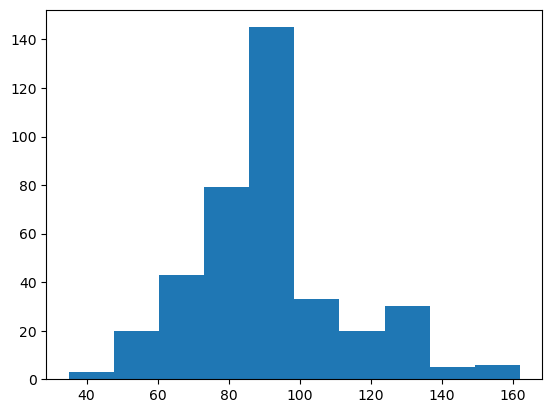

In [5]:
plt.hist(counts)
plt.show()

# LOAD DATA LYON

In [2]:
sujet_list = np.array(['01PD','02MJ','03VN','04GB','05LV','06EF','07PB','08DM','09TA','10BH','11FA','12BD','13FP',
'14MD','15LG','16GM','17JR','18SE','19TM','20TY','21ZV','22DI','23LF','24TJ','25DF','26MN','27BD','28NT','29SC',
'30AR','31HJ','32CM','33MA']) #exclude PB07
session_list = np.array(['o', '+', '-'])
cond_list = np.array(['FR_CV_1', 'MECA', 'CO2', 'FR_CV_2'])

In [3]:
metric_tot = ['inspi_index', 'expi_index', 'next_inspi_index',
       'inspi_time', 'expi_time', 'next_inspi_time', 'cycle_duration',
       'inspi_duration', 'expi_duration', 'cycle_freq', 'inspi_volume',
       'expi_volume', 'total_amplitude', 'inspi_amplitude', 'expi_amplitude',
       'select']

In [4]:
metric_list = ['inspi_duration', 'expi_duration', 'cycle_freq', 'total_amplitude']

In [5]:
xr_dict = {'sujet' : sujet_list, 'cond' : cond_list, 'session' : session_list, 'metric' : metric_list, 'time' : np.arange(1000)}
xr_data = np.zeros((sujet_list.shape[0], cond_list.shape[0], session_list.shape[0], len(metric_list), 1000))
xr_respi = xr.DataArray(xr_data, dims=xr_dict.keys(), coords=xr_dict.values())

In [6]:
# sujet = 'PD01'
# session_i = 'o'
# cond = 'FR_CV1'

for sujet in sujet_list:

    os.chdir(os.path.join(path_results, sujet,'RESPI'))

    for cond in cond_list:

        for session_i in session_list:

            file_df = f'{sujet}_{cond}_{session_i}_respfeatures.xlsx'
            raw_df = pd.read_excel(file_df)

            for metric in metric_list:

                respi_vals = raw_df[metric].values

                f = scipy.interpolate.interp1d(np.linspace(0, 1, respi_vals.shape[0]), respi_vals, kind='linear')
                respi_vals_resampled = f(np.linspace(0, 1, 1000))

                xr_respi.loc[sujet, cond, session_i, metric, :] = respi_vals_resampled


In [7]:
for sujet_i, sujet in enumerate(sujet_list):

    os.chdir(os.path.join(path_results, sujet,'RESPI'))

    for cond_i, cond in enumerate(cond_list):

        for session_i, session in enumerate(session_list):

            df_raw = pd.read_excel(f'{sujet}_{cond}_{session}_respfeatures.xlsx').query("select == 1").drop(columns=['Unnamed: 0', 'select'])
            df_raw_cols = df_raw.columns.values
            raw_mean = df_raw.mean(axis=0).values.reshape(1,-1)
            df_mean_i = pd.DataFrame(data=raw_mean, columns=df_raw_cols)
            
            df_header = pd.DataFrame({'sujet' : [sujet], 'cond' : [cond], 'session' : [session]})
            df_mean_i = pd.concat((df_header, df_mean_i), axis=1)

            if sujet_i+cond_i+session_i == 0:
                df_allsujet = df_mean_i
            else:
                df_allsujet = pd.concat((df_allsujet, df_mean_i), axis=0)

In [8]:
df_allsujet

,sujet,cond,session,inspi_index,expi_index,next_inspi_index,inspi_time,expi_time,next_inspi_time,cycle_duration,inspi_duration,expi_duration,cycle_freq,inspi_volume,expi_volume,total_amplitude,inspi_amplitude,expi_amplitude
0,01PD,FR_CV_1,o,76335.564103,77900.923077,79930.307692,152.671128,155.801846,159.860615,7.189487,3.130718,4.058769,0.153671,0.092501,0.020709,0.052332,0.034673,0.017659
0,01PD,FR_CV_1,+,77006.844444,78261.444444,80054.911111,154.013689,156.522889,160.109822,6.096133,2.509200,3.586933,0.177857,0.077336,0.042545,0.069889,0.038992,0.030897
0,01PD,FR_CV_1,-,78196.912281,79166.947368,80668.736842,156.393825,158.333895,161.337474,4.943649,1.940070,3.003579,0.217285,0.061781,0.028402,0.063658,0.041317,0.022341
0,01PD,MECA,o,69497.479167,70887.416667,72405.041667,138.994958,141.774833,144.810083,5.815125,2.779875,3.035250,0.187561,0.073371,0.021116,0.052300,0.029669,0.022631
0,01PD,MECA,+,67199.282609,68516.782609,70236.913043,134.398565,137.033565,140.473826,6.075261,2.635000,3.440261,0.186719,0.086911,0.051291,0.077096,0.041954,0.035142
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,33MA,CO2,+,75876.333333,77112.070175,78358.403509,151.752667,154.224140,156.716807,4.964140,2.471474,2.492667,0.203633,1133.517304,327.091096,879.832333,583.577395,296.254938
0,33MA,CO2,-,76051.280702,77222.736842,78516.017544,152.102561,154.445474,157.032035,4.929474,2.342912,2.586561,0.212451,1156.362188,563.451914,1113.618110,659.013521,454.604588
0,33MA,FR_CV_2,o,75316.402439,76177.280488,77065.317073,150.632805,152.354561,154.130634,3.497829,1.721756,1.776073,0.289536,623.954302,77.067612,614.789548,437.841898,176.947650
0,33MA,FR_CV_2,+,72746.115385,73623.897436,74553.858974,145.492231,147.247795,149.107718,3.615487,1.755564,1.859923,0.282490,730.588972,145.455738,726.844218,513.172517,213.671701


In [9]:
df_allsujet = df_allsujet[['sujet', 'cond', 'session']+metric_list]

In [10]:
sujet_best = np.array(['BD12', 'CM32', 'DI22', 'FA11', 'GM16', 'HJ31', 'JR17', 'MA33',
       'MJ02', 'MN26', 'PD01', 'SC29', 'TA09', 'TJ24', 'TM19', 'VN03',
       'ZV21'], dtype=object)
sujet_best_balanced = np.array([sujet for sujet in sujet_best if sujet != 'PD01'])

In [11]:
for row_i in range(df_allsujet.shape[0]):

    df_allsujet['sujet'].iloc[row_i] = f"{df_allsujet['sujet'].iloc[row_i][-2:]}{df_allsujet['sujet'].iloc[row_i][:2]}"

df_allsujet

/tmp/ipykernel_12912/563462661.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_allsujet['sujet'].iloc[row_i] = f"{df_allsujet['sujet'].iloc[row_i][-2:]}{df_allsujet['sujet'].iloc[row_i][:2]}"


,sujet,cond,session,inspi_duration,expi_duration,cycle_freq,total_amplitude
0,PD01,FR_CV_1,o,3.130718,4.058769,0.153671,0.052332
0,PD01,FR_CV_1,+,2.509200,3.586933,0.177857,0.069889
0,PD01,FR_CV_1,-,1.940070,3.003579,0.217285,0.063658
0,PD01,MECA,o,2.779875,3.035250,0.187561,0.052300
0,PD01,MECA,+,2.635000,3.440261,0.186719,0.077096
...,...,...,...,...,...,...,...
0,MA33,CO2,+,2.471474,2.492667,0.203633,879.832333
0,MA33,CO2,-,2.342912,2.586561,0.212451,1113.618110
0,MA33,FR_CV_2,o,1.721756,1.776073,0.289536,614.789548
0,MA33,FR_CV_2,+,1.755564,1.859923,0.282490,726.844218


In [12]:
sujet_sel_mask = []

for row_i in range(df_allsujet.shape[0]):

    if df_allsujet['sujet'].iloc[row_i] in sujet_best:

        sujet_sel_mask.append('YES')

    else:

        sujet_sel_mask.append('NO')

df_allsujet['select_best'] = sujet_sel_mask
df_allsujet

/tmp/ipykernel_12912/2051229825.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_allsujet['select_best'] = sujet_sel_mask


,sujet,cond,session,inspi_duration,expi_duration,cycle_freq,total_amplitude,select_best
0,PD01,FR_CV_1,o,3.130718,4.058769,0.153671,0.052332,YES
0,PD01,FR_CV_1,+,2.509200,3.586933,0.177857,0.069889,YES
0,PD01,FR_CV_1,-,1.940070,3.003579,0.217285,0.063658,YES
0,PD01,MECA,o,2.779875,3.035250,0.187561,0.052300,YES
0,PD01,MECA,+,2.635000,3.440261,0.186719,0.077096,YES
...,...,...,...,...,...,...,...,...
0,MA33,CO2,+,2.471474,2.492667,0.203633,879.832333,YES
0,MA33,CO2,-,2.342912,2.586561,0.212451,1113.618110,YES
0,MA33,FR_CV_2,o,1.721756,1.776073,0.289536,614.789548,YES
0,MA33,FR_CV_2,+,1.755564,1.859923,0.282490,726.844218,YES


# EFFECT COND

## all sujet

/crnldata/cmo/multisite/DATA_MANIP/EEG_Paris_J/Script_Python_EEG_Paris_git/n0ter_stats.py:382: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  estimators = pd.concat([df.groupby(predictor).mean()[outcome].reset_index(), df.groupby(predictor).std()[outcome].reset_index()[outcome].rename('sd')], axis = 1).round(2).set_index(predictor)
/crnldata/cmo/multisite/DATA_MANIP/EEG_Paris_J/Script_Python_EEG_Paris_git/n0ter_stats.py:382: FutureWarning: The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  estimators = pd.concat([df.groupby(predictor).mean()[outcome].reset_index(), df.groupby(predictor).std()[outcome].reset_index()[outcome].rena

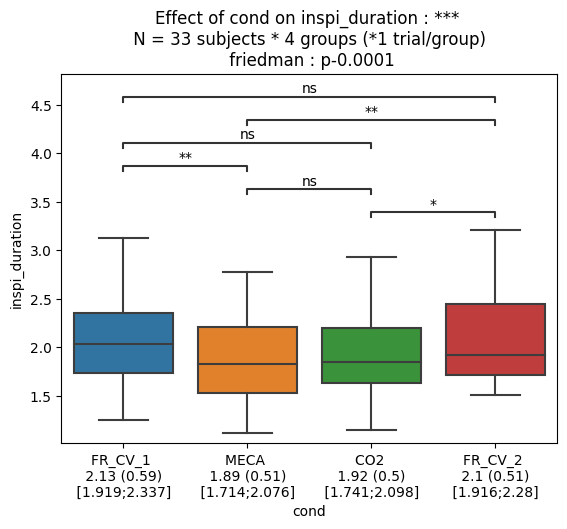

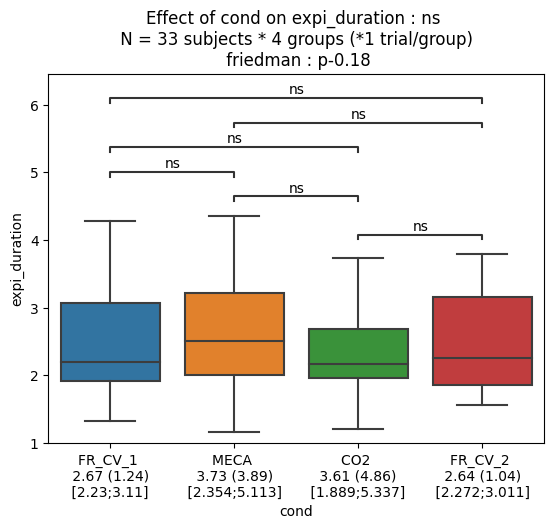

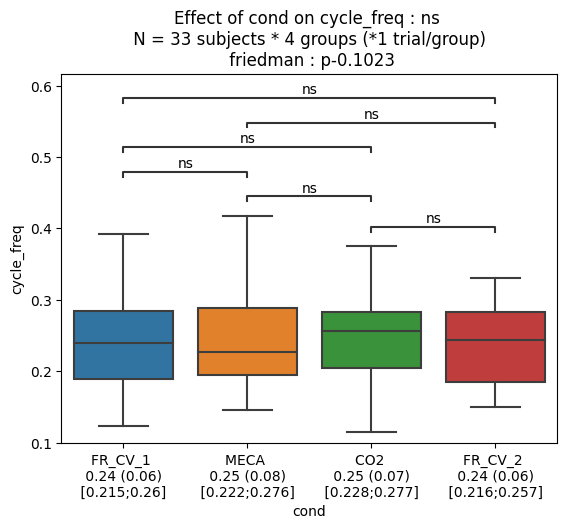

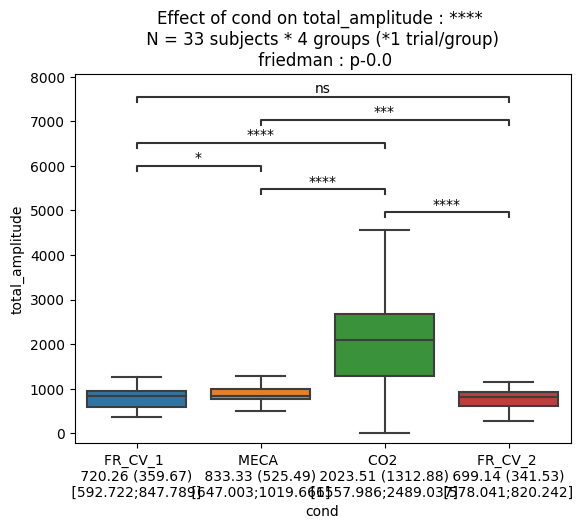

In [133]:
predictor = 'cond' 

for outcome_i in metric_list:

    fig, ax = plt.subplots()
    
    df_stats = df_allsujet.query(f"session == 'o'")
    ax = auto_stats(df_stats, predictor, outcome_i, ax=ax, subject='sujet', design='within', mode='box', transform=False, verbose=True, order=None)

## best sujet

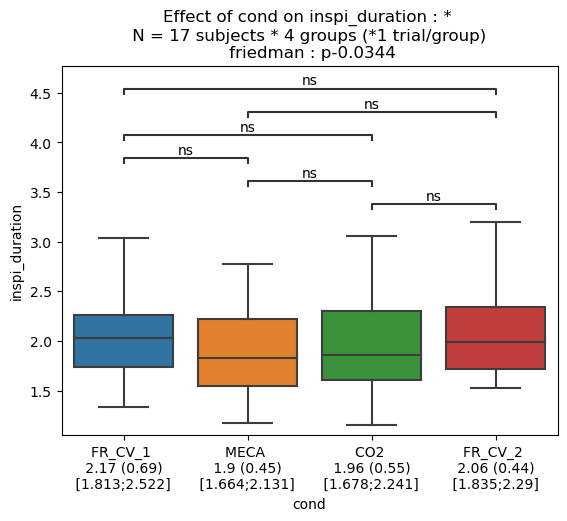

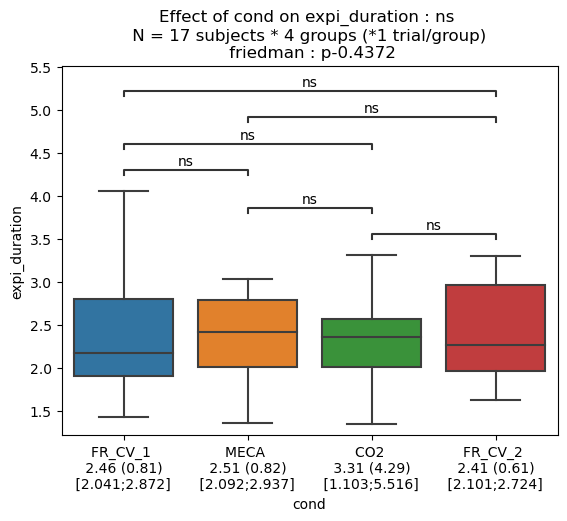

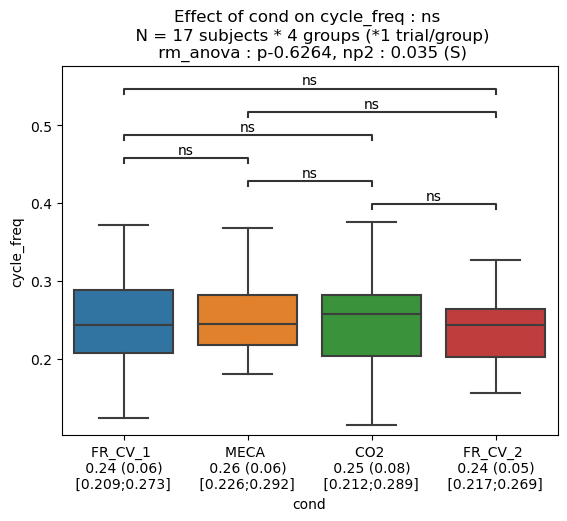

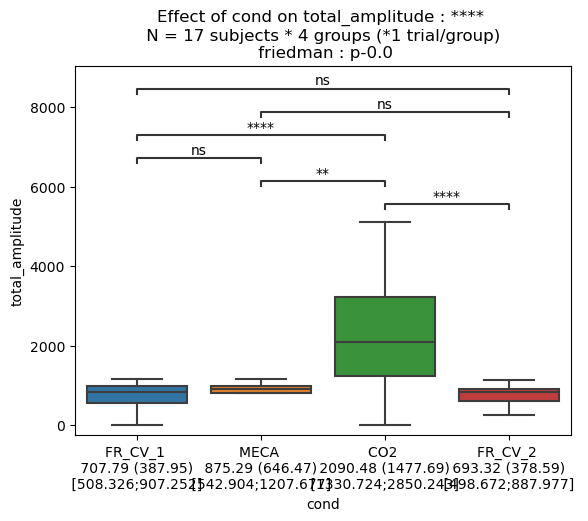

In [13]:
predictor = 'cond' 

for outcome_i in metric_list:

    fig, ax = plt.subplots()
    
    df_stats = df_allsujet.query(f"session == 'o' and select_best == 'YES'")
    ax = auto_stats(df_stats, predictor, outcome_i, ax=ax, subject='sujet', design='within', mode='box', transform=False, verbose=True, order=None)

## bad sujet

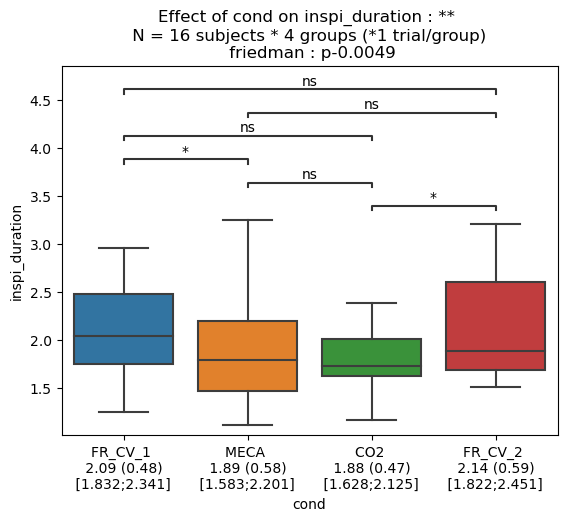

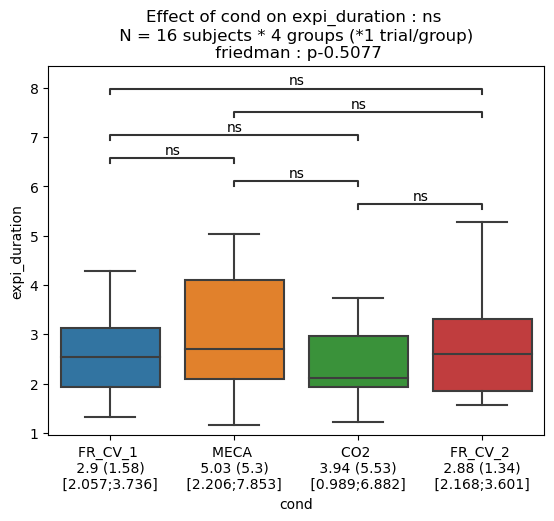

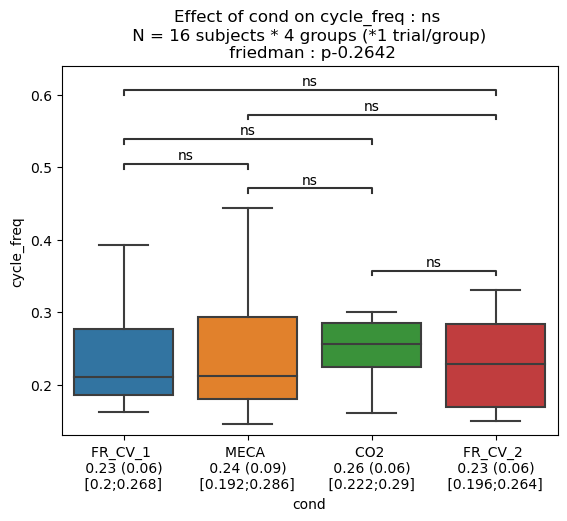

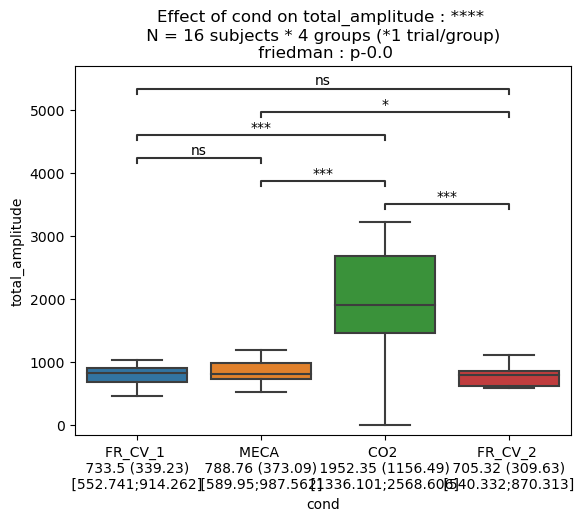

In [14]:
predictor = 'cond' 

for outcome_i in metric_list:

    fig, ax = plt.subplots()
    
    df_stats = df_allsujet.query(f"session == 'o' and select_best == 'NO'")
    ax = auto_stats(df_stats, predictor, outcome_i, ax=ax, subject='sujet', design='within', mode='box', transform=False, verbose=True, order=None)

# EFFECT ODOR

## allsujet

['FR_CV_1', 'MECA', 'CO2', 'FR_CV_2']


/crnldata/cmo/multisite/DATA_MANIP/EEG_Paris_J/Script_Python_EEG_Paris_git/n0ter_stats.py:382: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  estimators = pd.concat([df.groupby(predictor).mean()[outcome].reset_index(), df.groupby(predictor).std()[outcome].reset_index()[outcome].rename('sd')], axis = 1).round(2).set_index(predictor)
/crnldata/cmo/multisite/DATA_MANIP/EEG_Paris_J/Script_Python_EEG_Paris_git/n0ter_stats.py:382: FutureWarning: The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  estimators = pd.concat([df.groupby(predictor).mean()[outcome].reset_index(), df.groupby(predictor).std()[outcome].reset_index()[outcome].rena

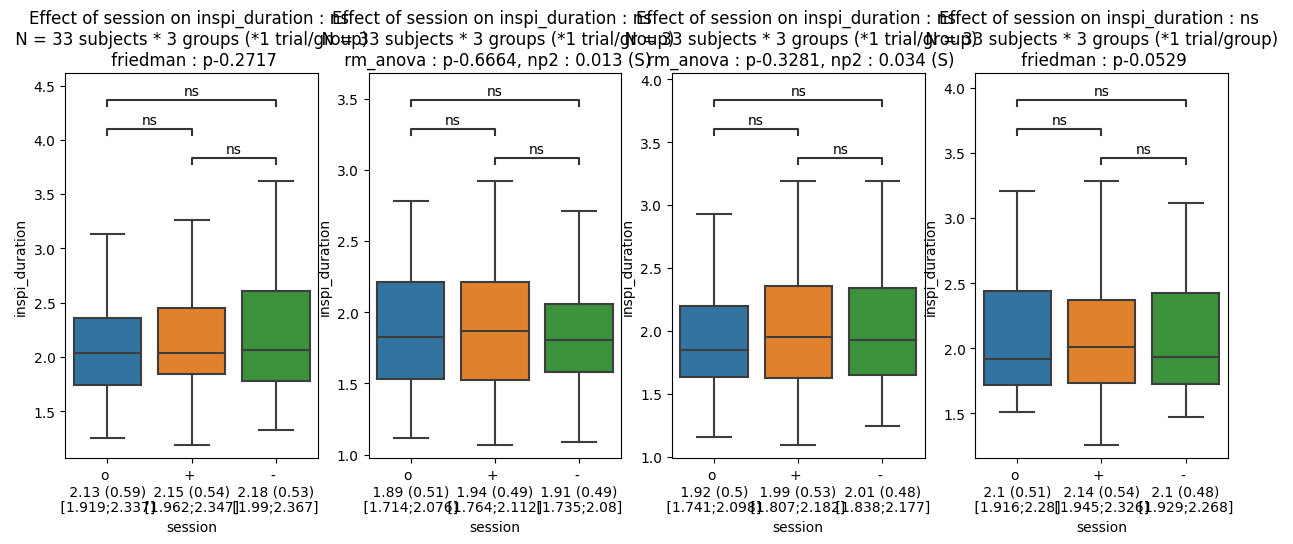

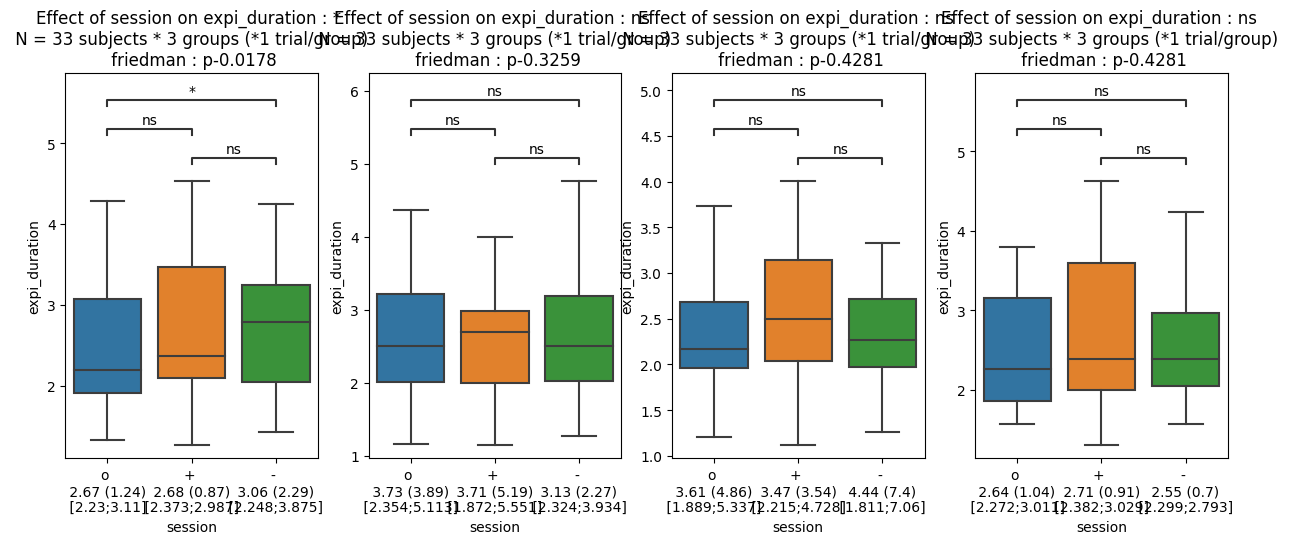

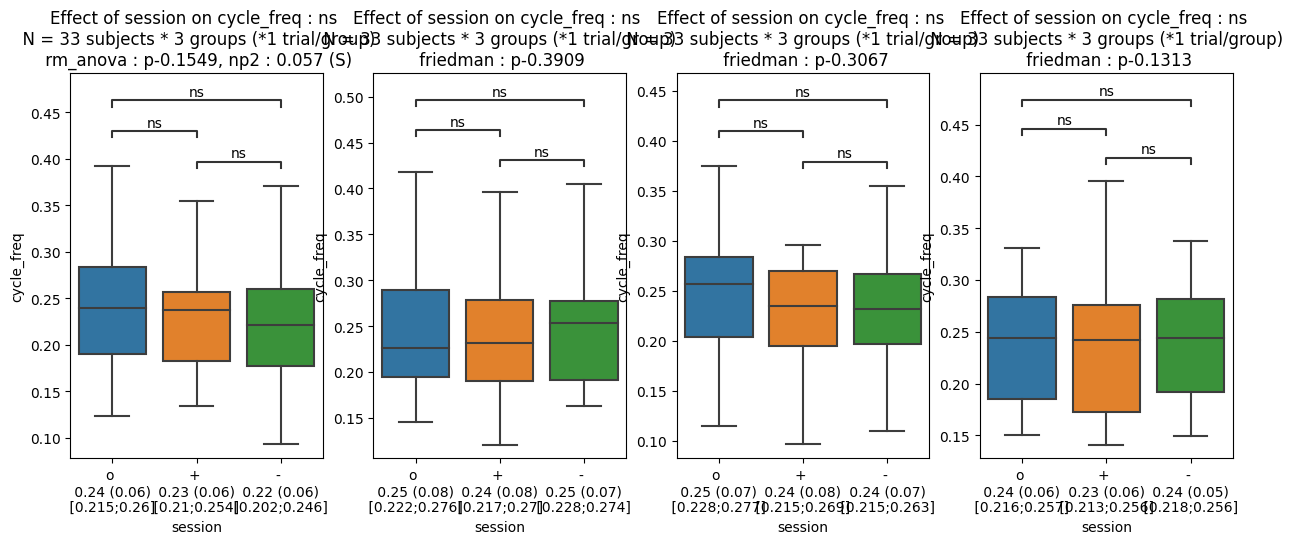

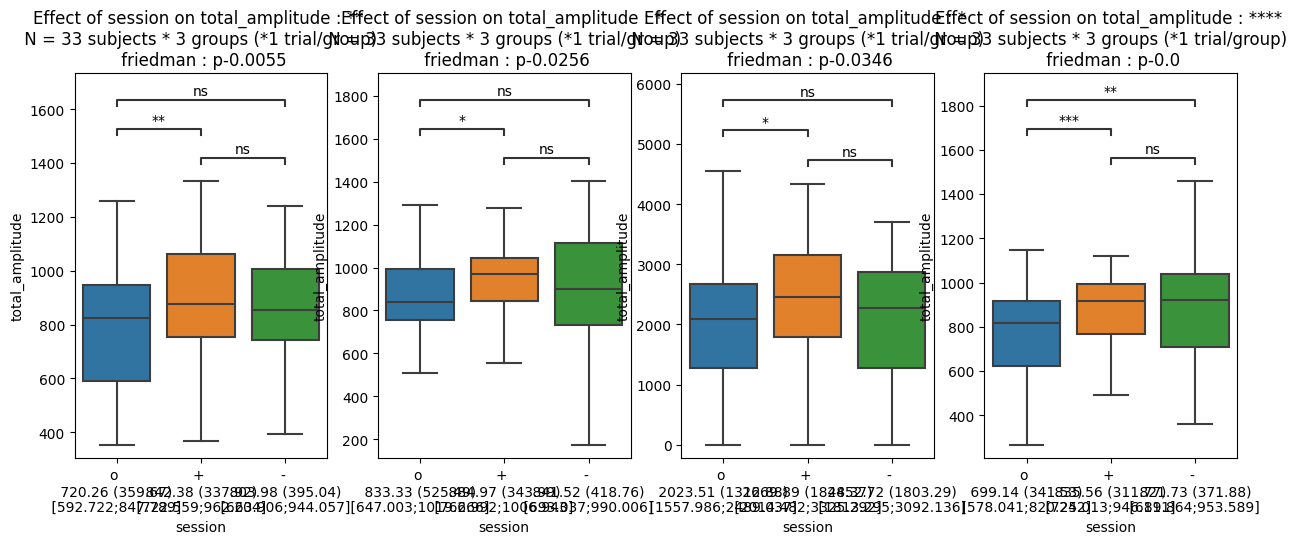

In [135]:
predictor = 'session' 

print(conditions)

for outcome_i in metric_list:

    fig, axs = plt.subplots(ncols=4)
    fig.set_figheight(5)
    fig.set_figwidth(15)

    for c, cond in enumerate(conditions):
        
        ax = axs[c]
        df_stats = df_allsujet.query(f"cond == '{cond}'")
        auto_stats(df_stats, predictor, outcome_i, ax=ax, subject='sujet', design='within', mode='box', transform=False, verbose=True, order=None)

## best sujet

['FR_CV_1', 'MECA', 'CO2', 'FR_CV_2']


/home/jules/anaconda3/lib/python3.8/site-packages/pingouin/distribution.py:977: RuntimeWarning: divide by zero encountered in double_scalars
  W = np.product(eig) / (eig.sum() / d) ** d
/home/jules/anaconda3/lib/python3.8/site-packages/pingouin/distribution.py:977: RuntimeWarning: divide by zero encountered in double_scalars
  W = np.product(eig) / (eig.sum() / d) ** d


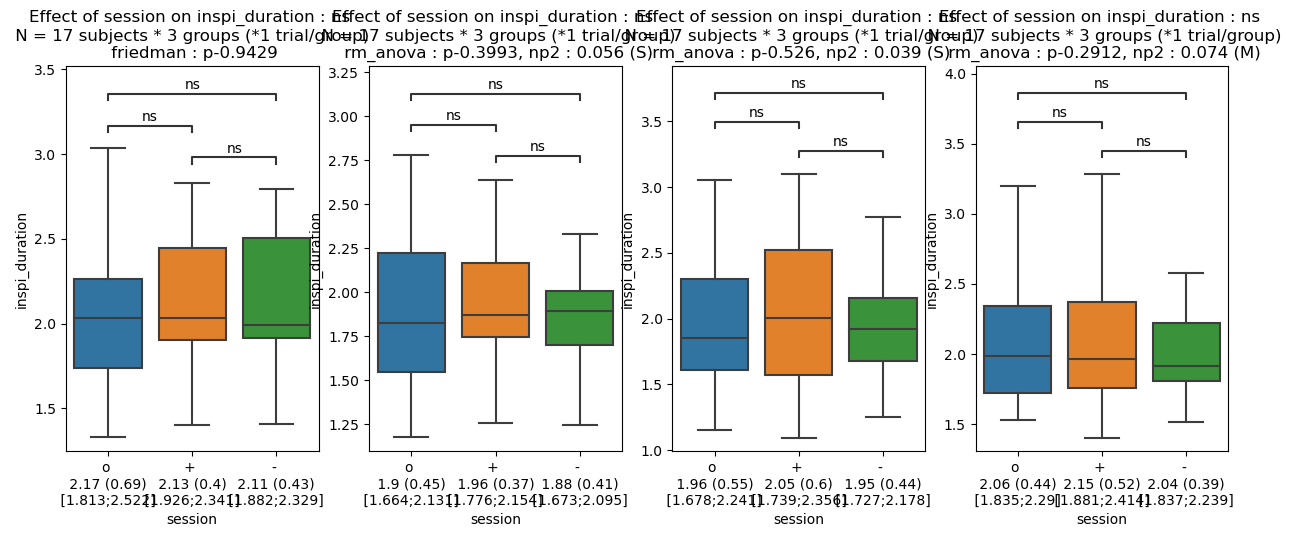

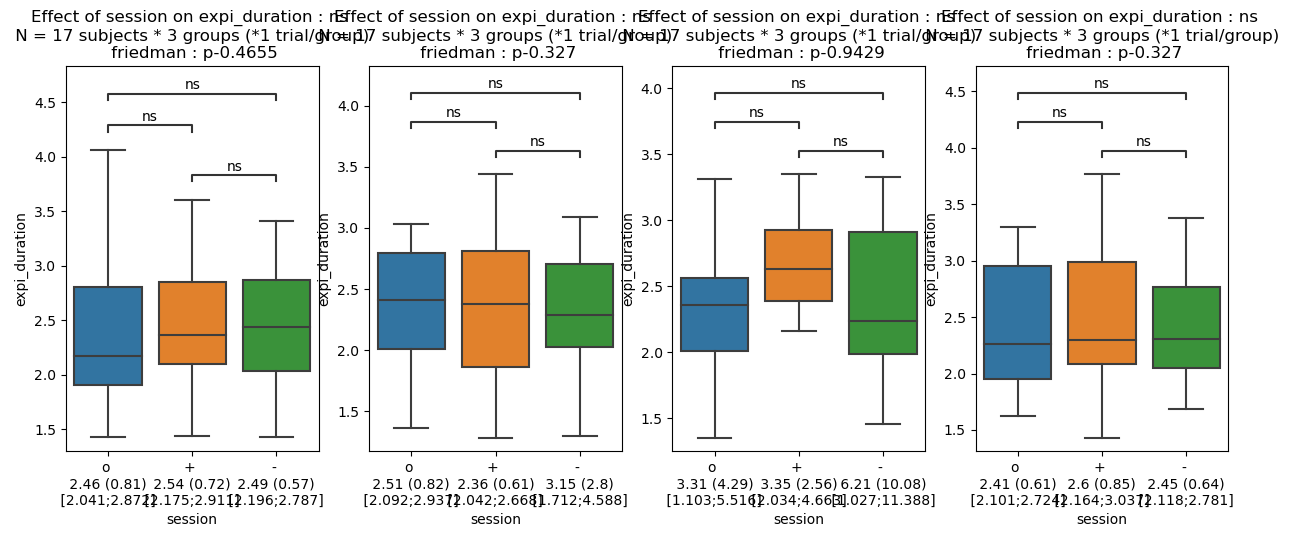

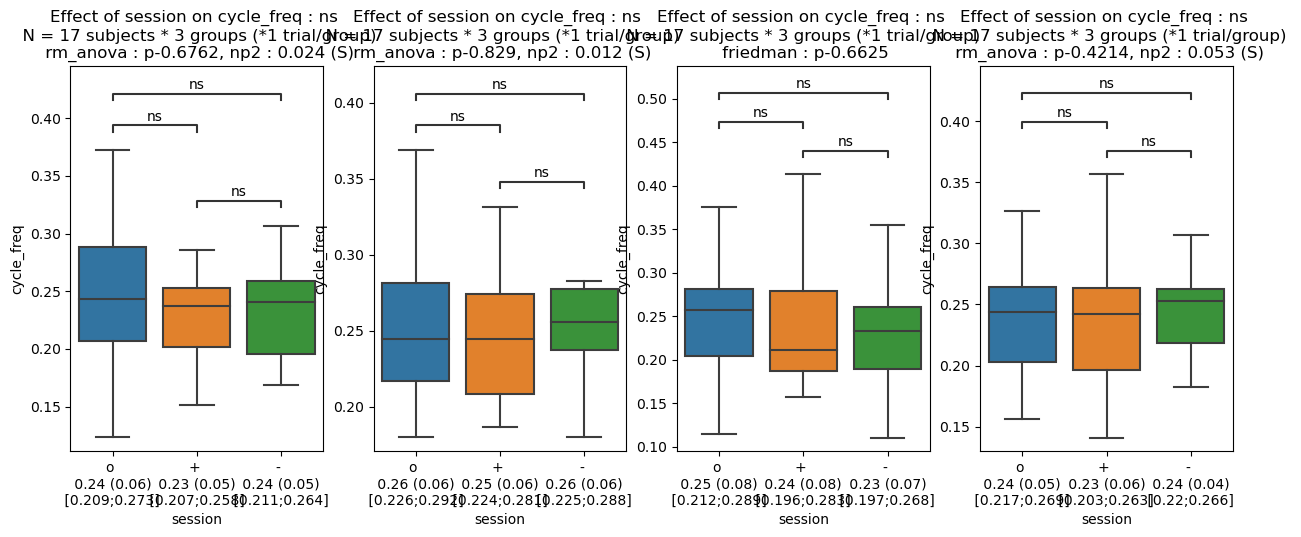

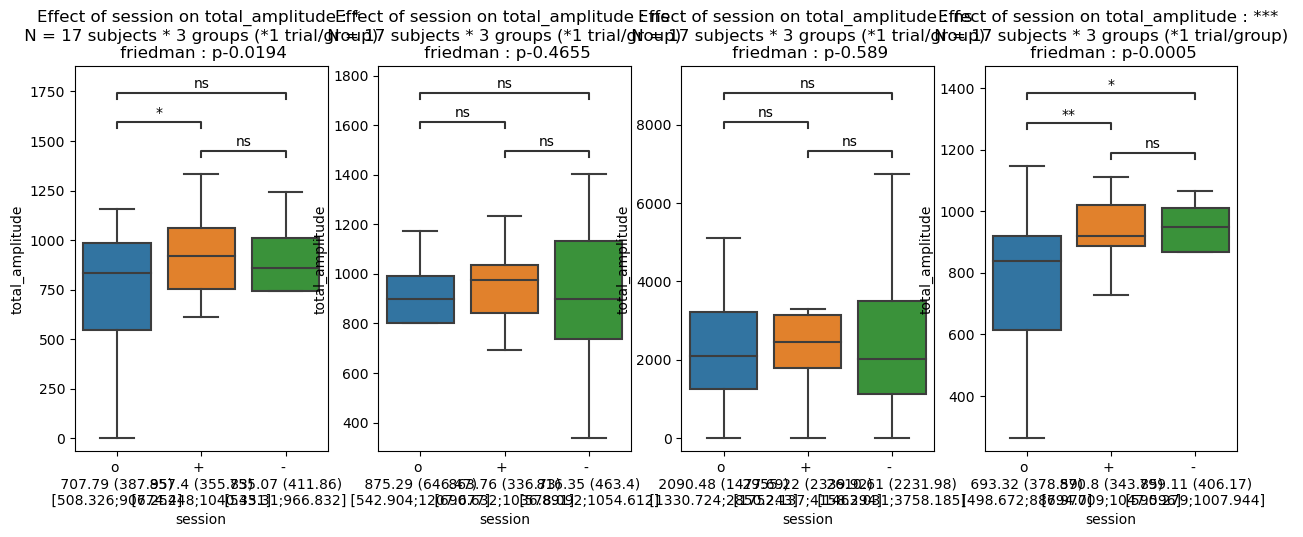

In [16]:
predictor = 'session' 

print(conditions)

for outcome_i in metric_list:

    fig, axs = plt.subplots(ncols=4)
    fig.set_figheight(5)
    fig.set_figwidth(15)

    for c, cond in enumerate(conditions):
        
        ax = axs[c]
        df_stats = df_allsujet.query(f"cond == '{cond}' and select_best == 'YES'")
        auto_stats(df_stats, predictor, outcome_i, ax=ax, subject='sujet', design='within', mode='box', transform=False, verbose=True, order=None)

## bad sujet

['FR_CV_1', 'MECA', 'CO2', 'FR_CV_2']


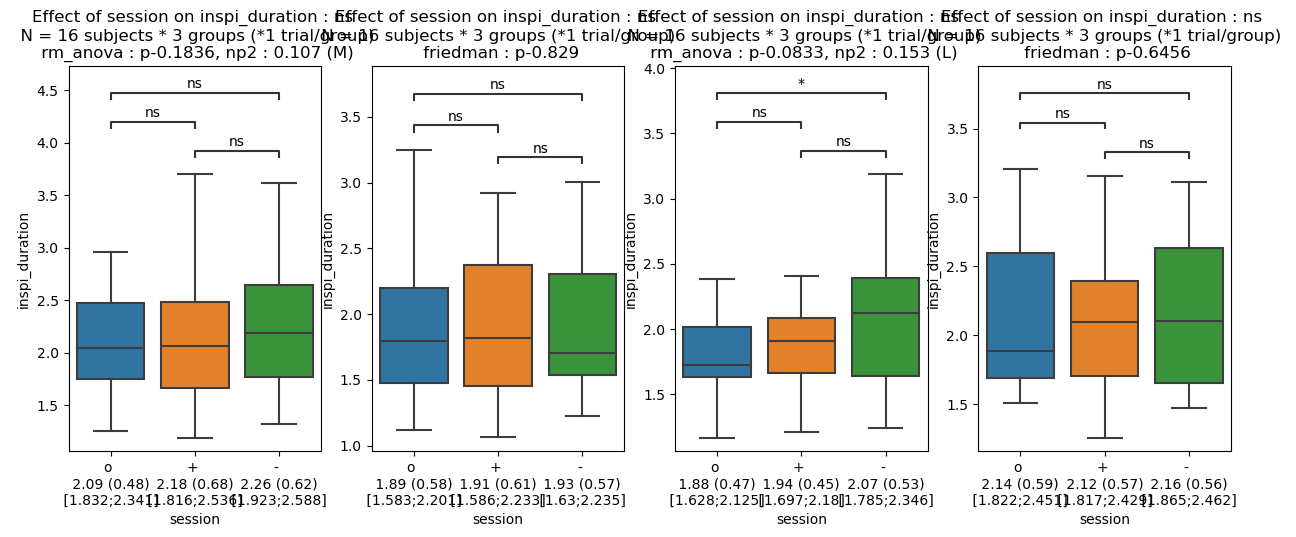

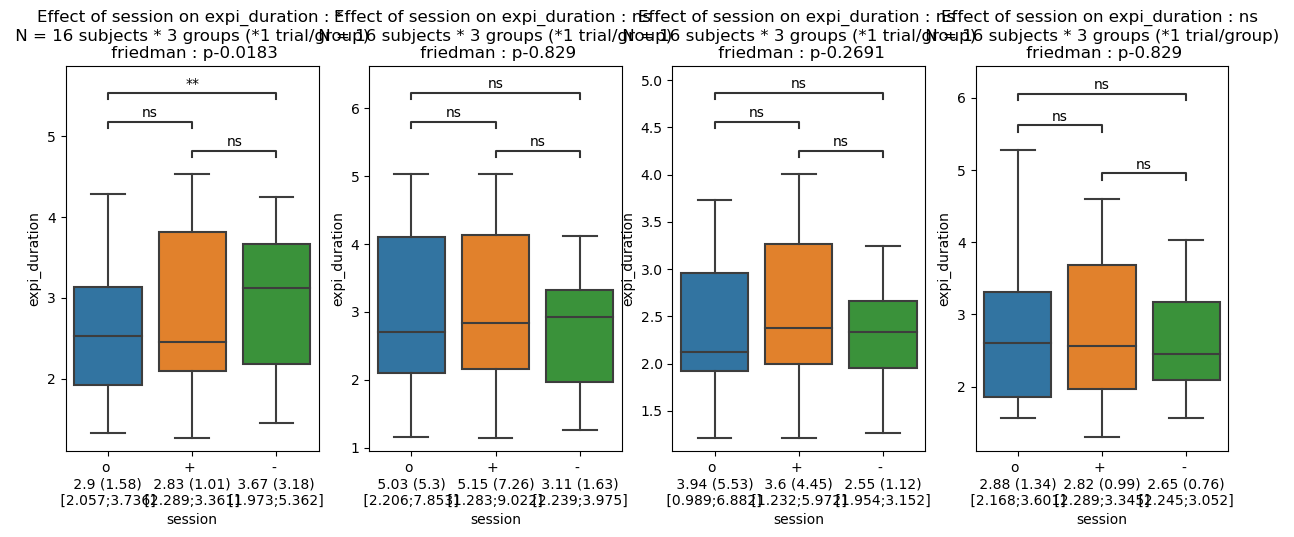

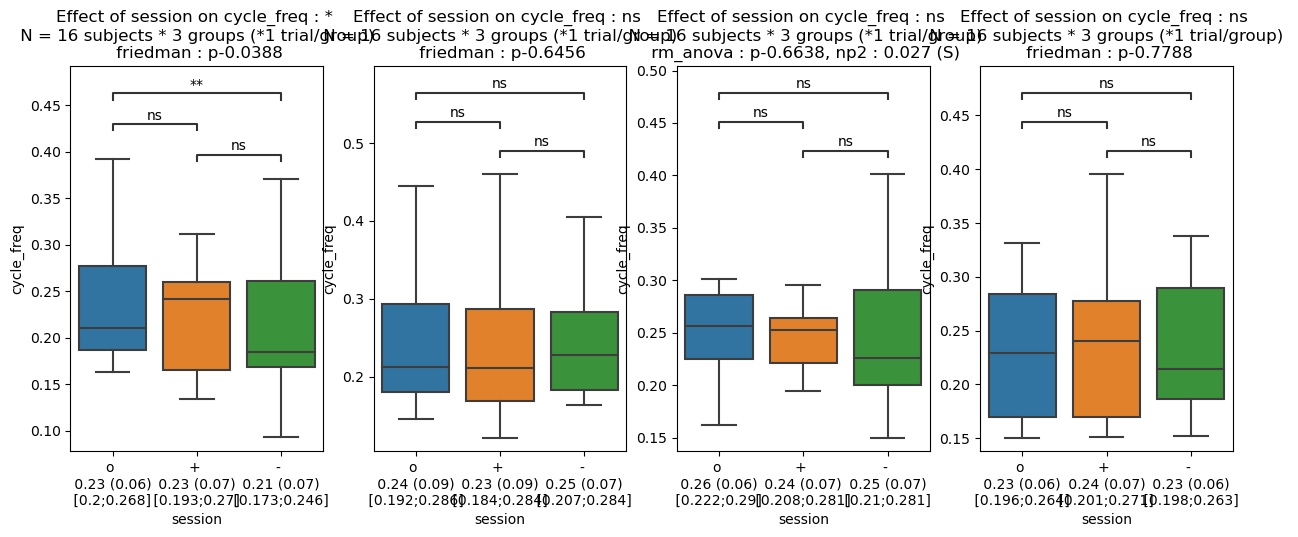

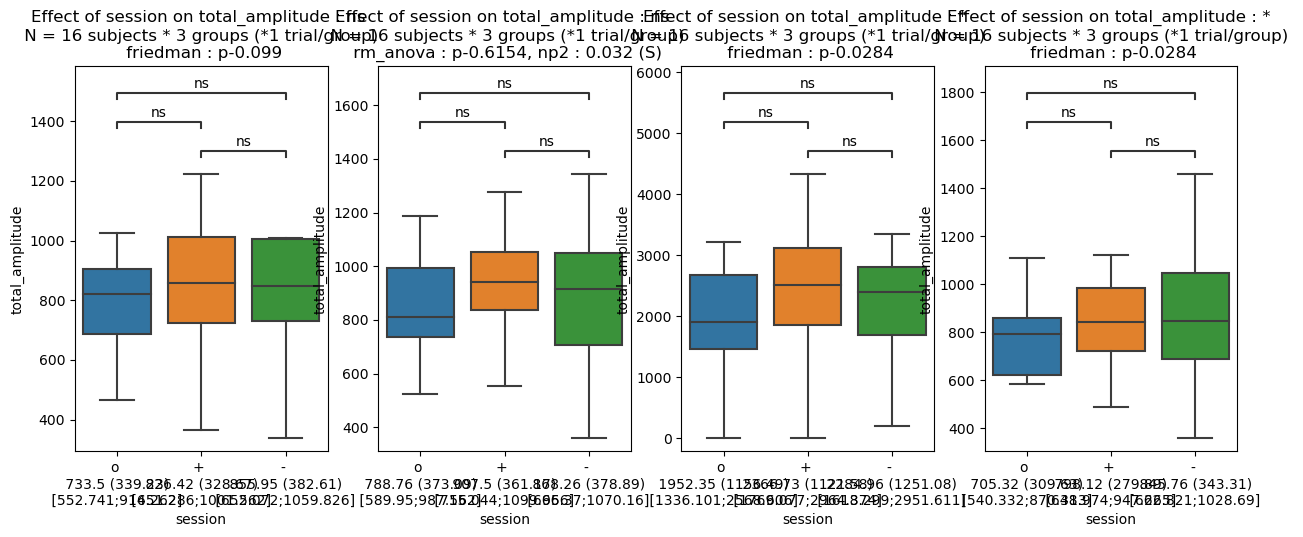

In [17]:
predictor = 'session' 

print(conditions)

for outcome_i in metric_list:

    fig, axs = plt.subplots(ncols=4)
    fig.set_figheight(5)
    fig.set_figwidth(15)

    for c, cond in enumerate(conditions):
        
        ax = axs[c]
        df_stats = df_allsujet.query(f"cond == '{cond}' and select_best == 'NO'")
        auto_stats(df_stats, predictor, outcome_i, ax=ax, subject='sujet', design='within', mode='box', transform=False, verbose=True, order=None)

# SIGNAL ACROSS TIME

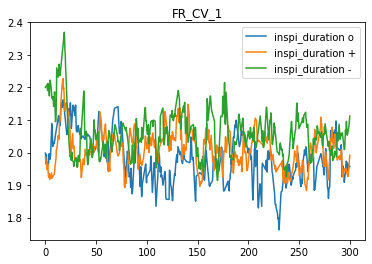

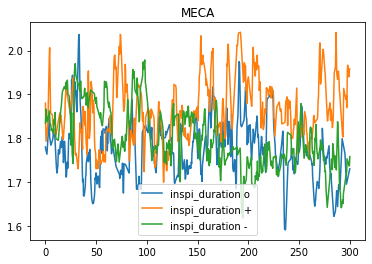

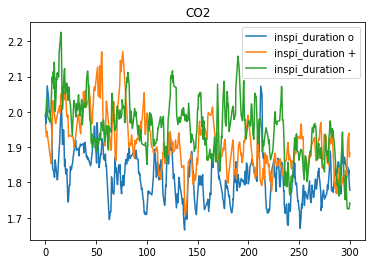

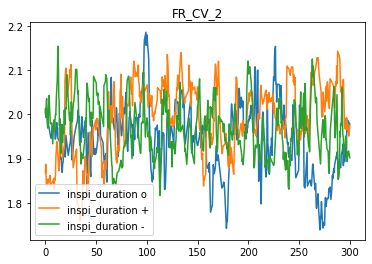

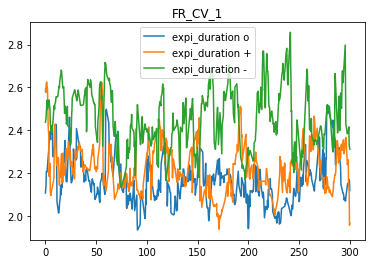

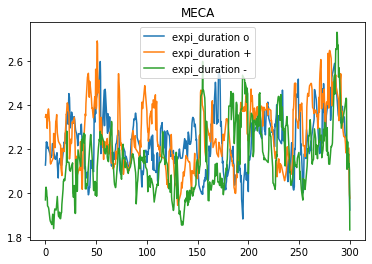

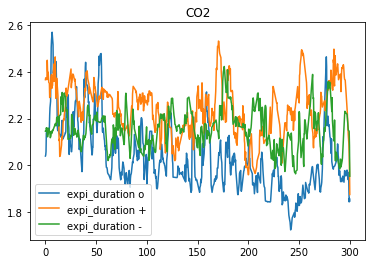

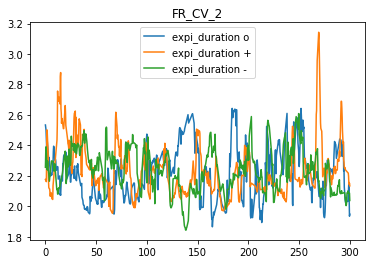

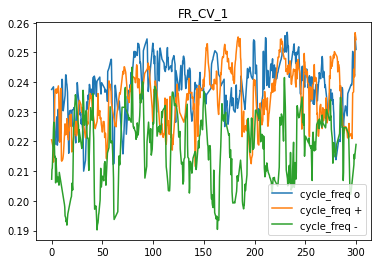

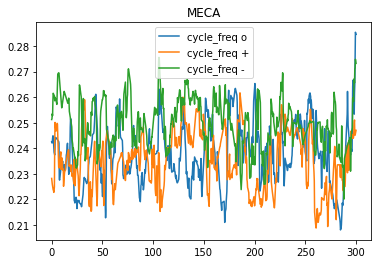

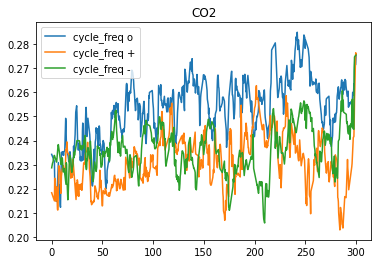

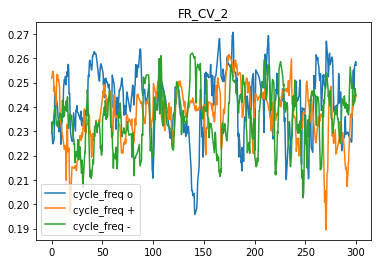

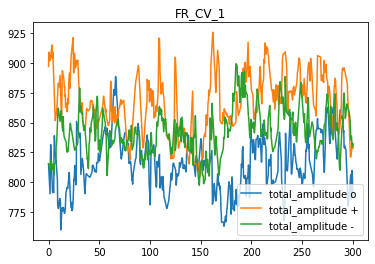

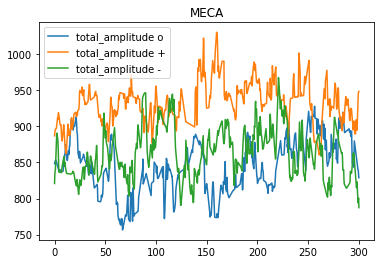

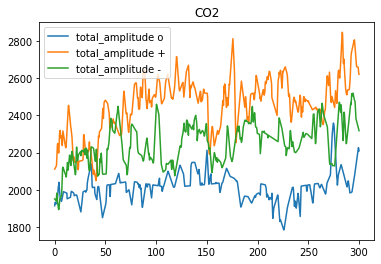

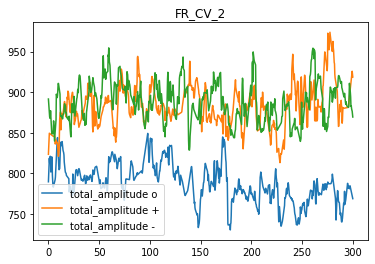

In [ ]:
for metric in metric_list:

    for cond in cond_list:

        for session_i in session_list:

            x = xr_respi.loc[:, cond, session_i, metric, :]
            x = np.median(x, axis=0)
            time = np.linspace(0,300,1000)
            plt.plot(time, x, label=f'{metric} {session_i}')

        plt.title(cond)
        plt.legend()
        plt.show()


# EFFECT ODOR CHUNK

## chunkdata

In [30]:
xr_respi

<xarray.DataArray (sujet: 33, cond: 4, session: 3, metric: 4, time: 1000)>
array([[[[[2.37200000e+00, 2.37248048e+00, 2.37296096e+00, ...,
           1.96056256e+00, 1.95928128e+00, 1.95800000e+00],
          [3.22000000e+00, 3.35045045e+00, 3.48090090e+00, ...,
           2.89065265e+00, 2.88432633e+00, 2.87800000e+00],
          [1.78826896e-01, 1.76184831e-01, 1.73542767e-01, ...,
           2.06156472e-01, 2.06469468e-01, 2.06782465e-01],
          [4.55322974e-02, 4.54599096e-02, 4.53875218e-02, ...,
           3.73973790e-02, 3.74008424e-02, 3.74043058e-02]],

         [[4.22600000e+00, 4.11429229e+00, 4.00258458e+00, ...,
           2.31997798e+00, 2.33498899e+00, 2.35000000e+00],
          [3.92600000e+00, 3.89975375e+00, 3.87350751e+00, ...,
           2.99683684e+00, 2.97841842e+00, 2.96000000e+00],
          [1.22669284e-01, 1.25951423e-01, 1.29233563e-01, ...,
           1.88085546e-01, 1.88204731e-01, 1.88323917e-01],
          [9.97246038e-02, 9.82158570e-02, 9.67071102e-02, ...,
           8.72807994e-02, 8.76465638e-02, 8.80123283e-02]],

         [[1.63600000e+00, 1.67698899e+00, 1.71797798e+00, ...,
           2.22304104e+00, 2.26252052e+00, 2.30200000e+00],
...
          [5.98897753e+02, 5.98246282e+02, 5.97594811e+02, ...,
           5.52343541e+02, 5.49777435e+02, 5.47211330e+02]],

         [[1.81000000e+00, 1.79797998e+00, 1.78595996e+00, ...,
           1.92285886e+00, 1.94942943e+00, 1.97600000e+00],
          [1.87400000e+00, 1.86356156e+00, 1.85312312e+00, ...,
           2.18653854e+00, 2.15126927e+00, 2.11600000e+00],
          [2.71444083e-01, 2.73237087e-01, 2.75030092e-01, ...,
           2.43367481e-01, 2.43873379e-01, 2.44379277e-01],
          [7.42882265e+02, 7.41619801e+02, 7.40357336e+02, ...,
           6.49504748e+02, 6.54052161e+02, 6.58599573e+02]],

         [[1.96000000e+00, 1.98383784e+00, 2.00767568e+00, ...,
           1.60205405e+00, 1.61302703e+00, 1.62400000e+00],
          [2.13600000e+00, 2.14634234e+00, 2.15668468e+00, ...,
           1.86400000e+00, 1.85000000e+00, 1.83600000e+00],
          [2.44140625e-01, 2.42341408e-01, 2.40542190e-01, ...,
           2.88518559e-01, 2.88767950e-01, 2.89017341e-01],
          [6.10992034e+02, 6.12235762e+02, 6.13479491e+02, ...,
           4.57299270e+02, 4.58953558e+02, 4.60607845e+02]]]]])
Coordinates:
  * sujet    (sujet) <U4 '01PD' '02MJ' '03VN' '04GB' ... '31HJ' '32CM' '33MA'
  * cond     (cond) <U7 'FR_CV_1' 'MECA' 'CO2' 'FR_CV_2'
  * session  (session) <U1 'o' '+' '-'
  * metric   (metric) <U15 'inspi_duration' ... 'total_amplitude'
  * time     (time) int64 0 1 2 3 4 5 6 7 8 ... 992 993 994 995 996 997 998 999

In [29]:
sec_to_chunk = 10

In [70]:
i_chunk = (10*xr_respi['time'].shape[0])/300
df_respi_chunk = xr_respi.loc[:, :, :, :, :i_chunk].median(['time']).to_dataframe(name='').reset_index()
df_respi_chunk = df_respi_chunk.rename(columns={'': 'value'})

for row_i in range(df_respi_chunk.shape[0]):

    df_respi_chunk['sujet'].iloc[row_i] = f"{df_respi_chunk['sujet'].iloc[row_i][-2:]}{df_respi_chunk['sujet'].iloc[row_i][:2]}"


/tmp/ipykernel_2317687/409480136.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_respi_chunk['sujet'].iloc[row_i] = f"{df_respi_chunk['sujet'].iloc[row_i][-2:]}{df_respi_chunk['sujet'].iloc[row_i][:2]}"


In [71]:
data = {'sujet' : [], 'cond' : [], 'session' : []}

for metric in df_respi_chunk['metric'].unique():

    data[metric] = []

for sujet in df_respi_chunk['sujet'].unique():

    for cond in df_respi_chunk['cond'].unique():

        for session in df_respi_chunk['session'].unique():

            data['sujet'].append(sujet)
            data['cond'].append(cond)
            data['session'].append(session)

            for metric in df_respi_chunk['metric'].unique():

                data[metric].append(df_respi_chunk.query(f"sujet == '{sujet}' and cond == '{cond}' and session == '{session}' and metric == '{metric}'")['value'].values[0])

df_respi_chunk = pd.DataFrame(data)
df_respi_chunk

,sujet,cond,session,inspi_duration,expi_duration,cycle_freq,total_amplitude
0,PD01,FR_CV_1,o,2.376565,5.363066,0.135983,0.044845
1,PD01,FR_CV_1,+,2.382823,3.533166,0.176825,0.074830
2,PD01,FR_CV_1,-,2.110252,3.091931,0.194036,0.062779
3,PD01,MECA,o,2.249814,2.838517,0.199156,0.039202
4,PD01,MECA,+,2.405626,2.406748,0.209356,0.102074
...,...,...,...,...,...,...,...
391,MA33,CO2,+,2.730258,2.548166,0.191156,873.623768
392,MA33,CO2,-,2.620709,2.718961,0.188115,738.833538
393,MA33,FR_CV_2,o,1.726414,2.036417,0.268783,593.360251
394,MA33,FR_CV_2,+,1.694549,1.776030,0.288589,726.409347


## allsujet odor

['FR_CV_1', 'MECA', 'CO2', 'FR_CV_2']


/home/jules.granget/myenvs/py39c/lib64/python3.9/site-packages/pingouin/parametric.py:551: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  ss_resall = grp_with.apply(lambda x: (x - x.mean()) ** 2).sum()
/crnldata/cmo/multisite/DATA_MANIP/EEG_Paris_J/Script_Python_EEG_Paris_git/n0ter_stats.py:382: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  estimators = pd.concat([df.groupby(predictor).mean()[outcome].reset_index(), df.groupby(predictor).std()[outcome]

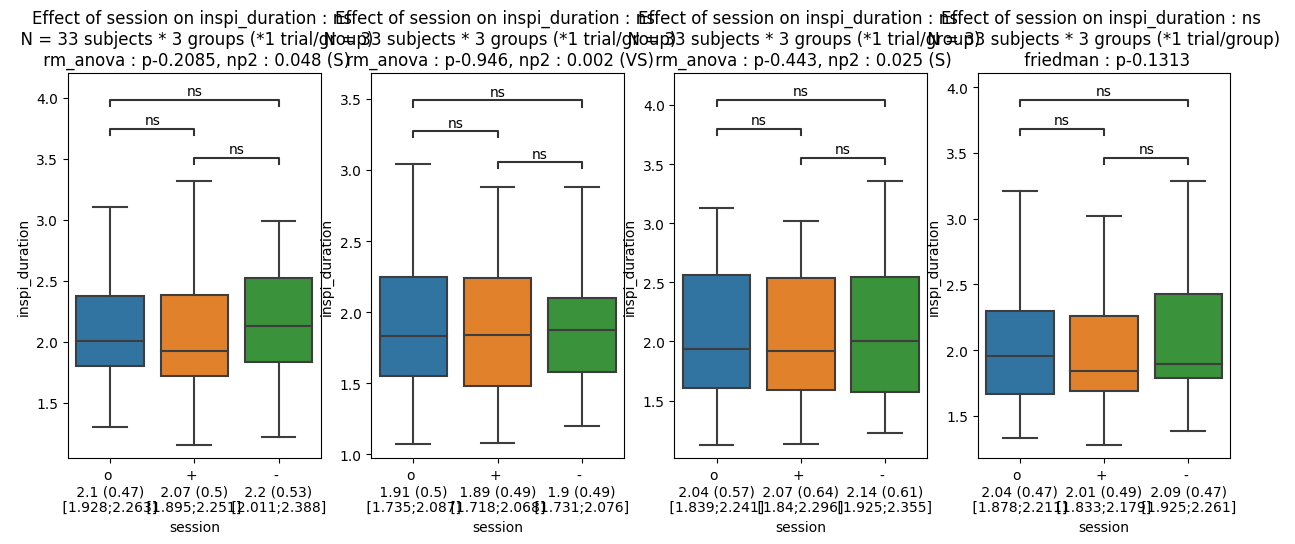

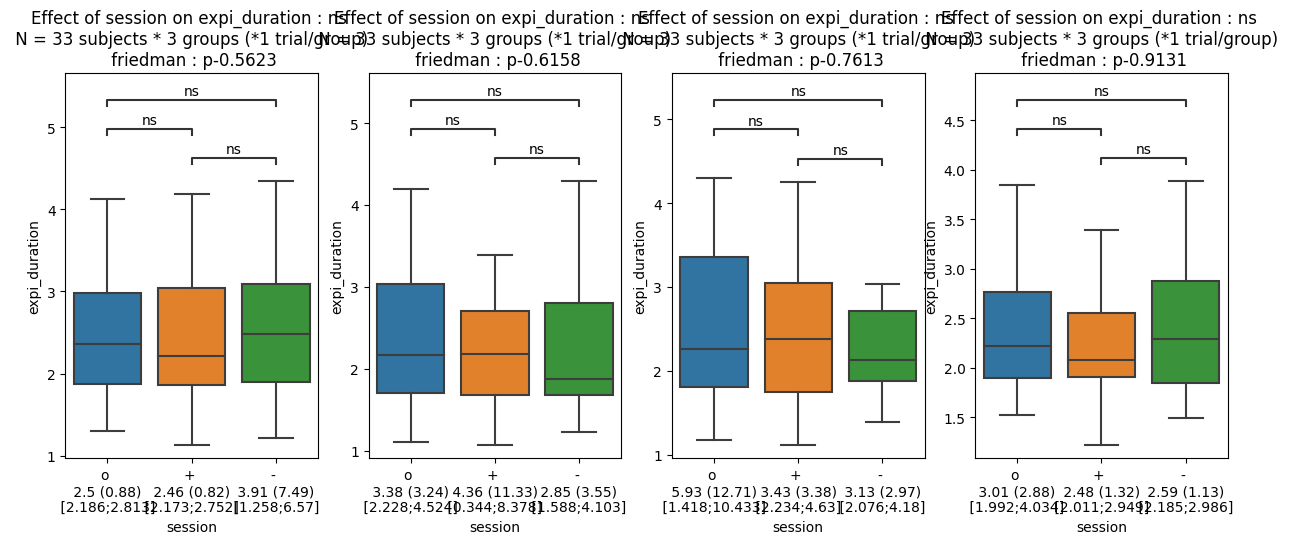

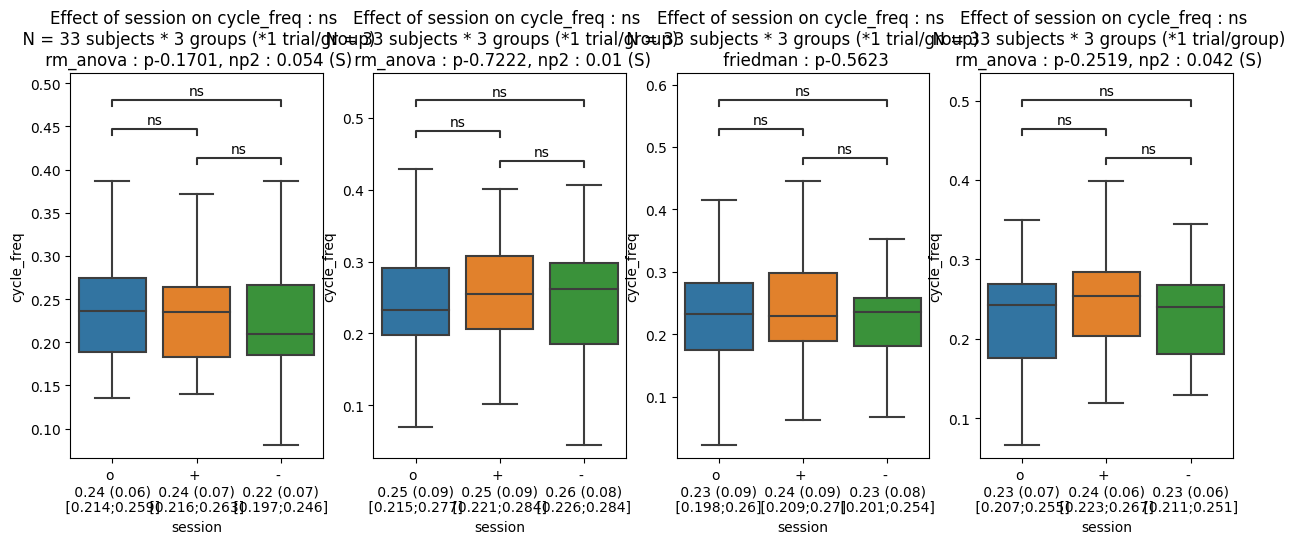

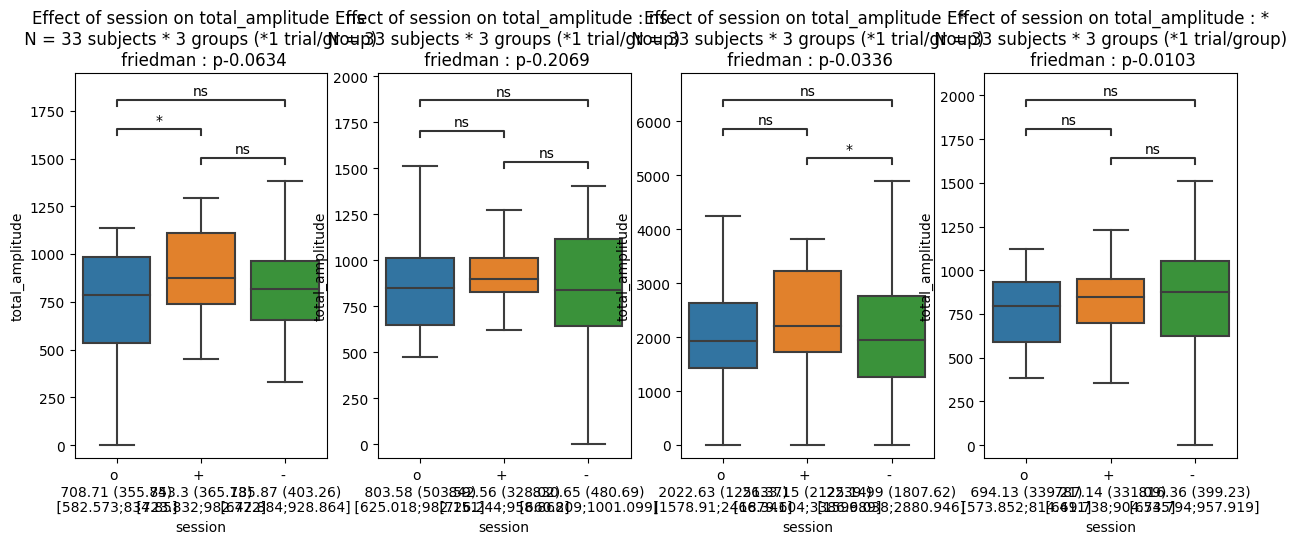

In [72]:
predictor = 'session' 

print(conditions)

for outcome_i in metric_list:

    fig, axs = plt.subplots(ncols=4)
    fig.set_figheight(5)
    fig.set_figwidth(15)

    for c, cond in enumerate(conditions):
        
        ax = axs[c]
        df_stats = df_respi_chunk.query(f"cond == '{cond}'")
        auto_stats(df_stats, predictor, outcome_i, ax=ax, subject='sujet', design='within', mode='box', transform=False, verbose=True, order=None)

## best sujet odor

['FR_CV_1', 'MECA', 'CO2', 'FR_CV_2']


/home/jules.granget/myenvs/py39c/lib64/python3.9/site-packages/pingouin/parametric.py:551: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  ss_resall = grp_with.apply(lambda x: (x - x.mean()) ** 2).sum()
/crnldata/cmo/multisite/DATA_MANIP/EEG_Paris_J/Script_Python_EEG_Paris_git/n0ter_stats.py:382: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  estimators = pd.concat([df.groupby(predictor).mean()[outcome].reset_index(), df.groupby(predictor).std()[outcome]

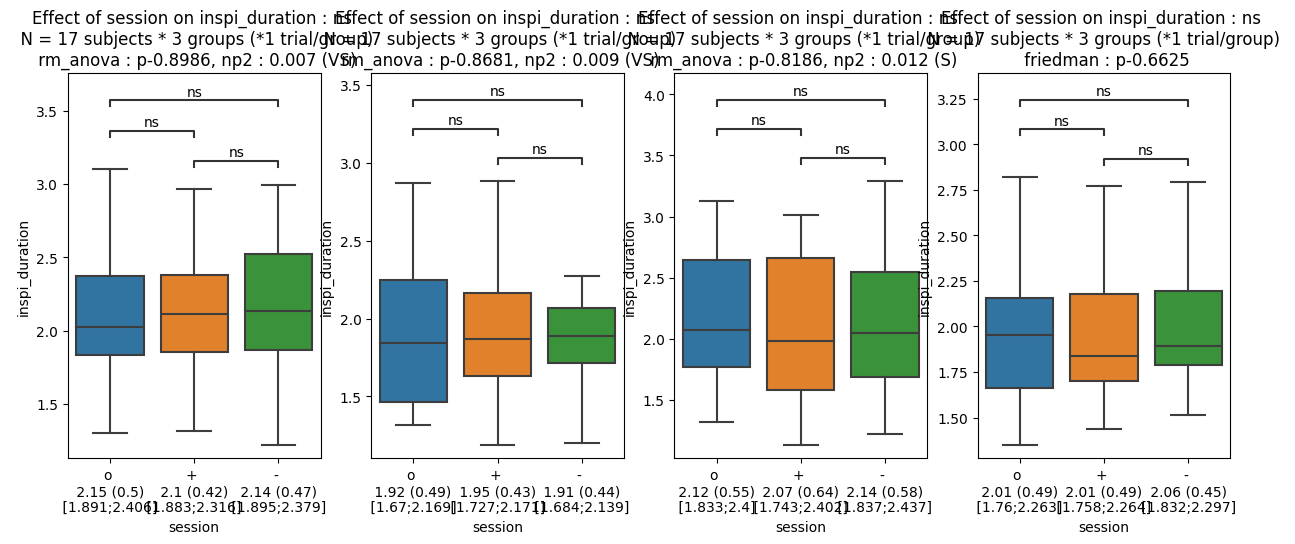

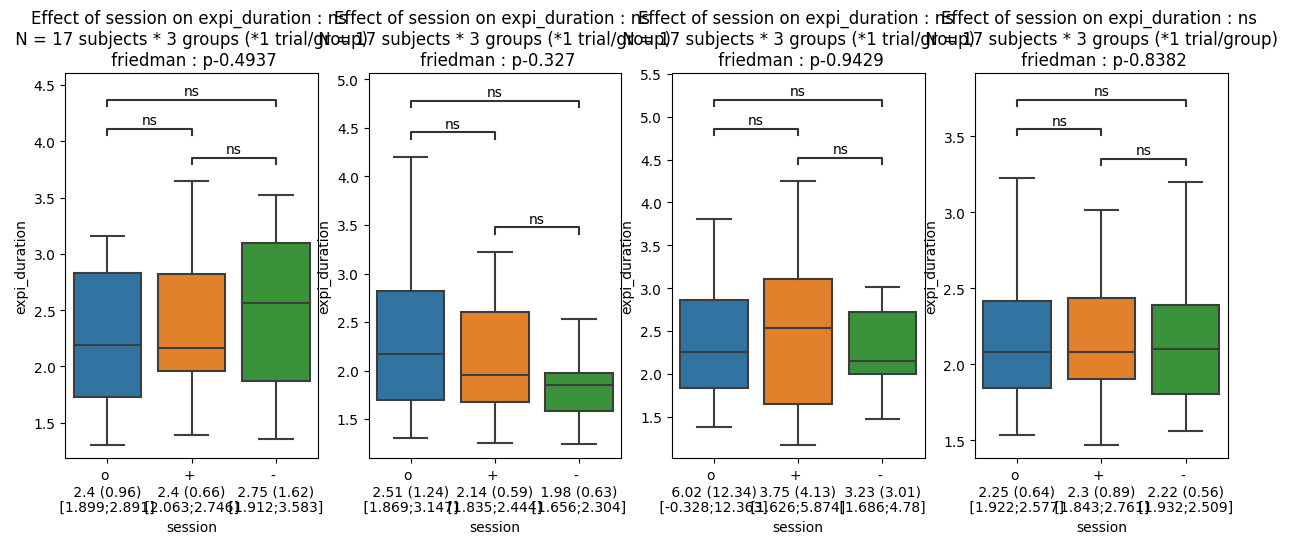

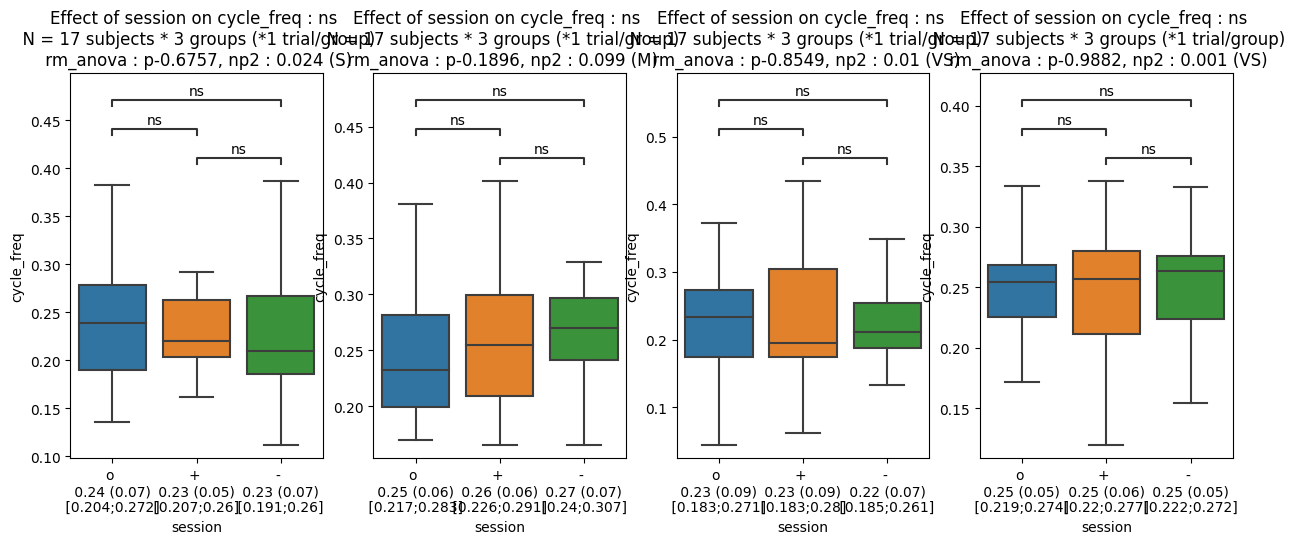

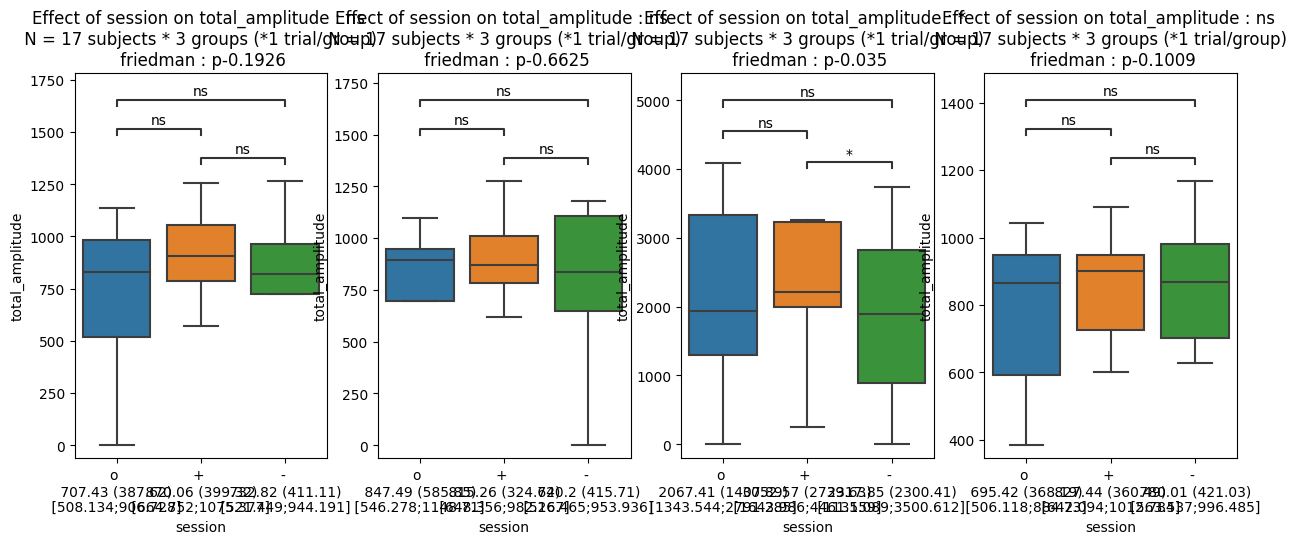

In [74]:
predictor = 'session' 

print(conditions)

for outcome_i in metric_list:

    fig, axs = plt.subplots(ncols=4)
    fig.set_figheight(5)
    fig.set_figwidth(15)

    for c, cond in enumerate(conditions):
        
        ax = axs[c]
        df_stats = df_respi_chunk.query(f"cond == '{cond}' and sujet in {sujet_best.tolist()}")
        auto_stats(df_stats, predictor, outcome_i, ax=ax, subject='sujet', design='within', mode='box', transform=False, verbose=True, order=None)

# PCA

## allsig respi

In [151]:
df_allsujet

,sujet,cond,session,inspi_duration,expi_duration,cycle_freq,total_amplitude,select_best
0,PD01,FR_CV_1,o,3.130718,4.058769,0.153671,0.052332,YES
0,PD01,FR_CV_1,+,2.509200,3.586933,0.177857,0.069889,YES
0,PD01,FR_CV_1,-,1.940070,3.003579,0.217285,0.063658,YES
0,PD01,MECA,o,2.779875,3.035250,0.187561,0.052300,YES
0,PD01,MECA,+,2.635000,3.440261,0.186719,0.077096,YES
...,...,...,...,...,...,...,...,...
0,MA33,CO2,+,2.471474,2.492667,0.203633,879.832333,YES
0,MA33,CO2,-,2.342912,2.586561,0.212451,1113.618110,YES
0,MA33,FR_CV_2,o,1.721756,1.776073,0.289536,614.789548,YES
0,MA33,FR_CV_2,+,1.755564,1.859923,0.282490,726.844218,YES


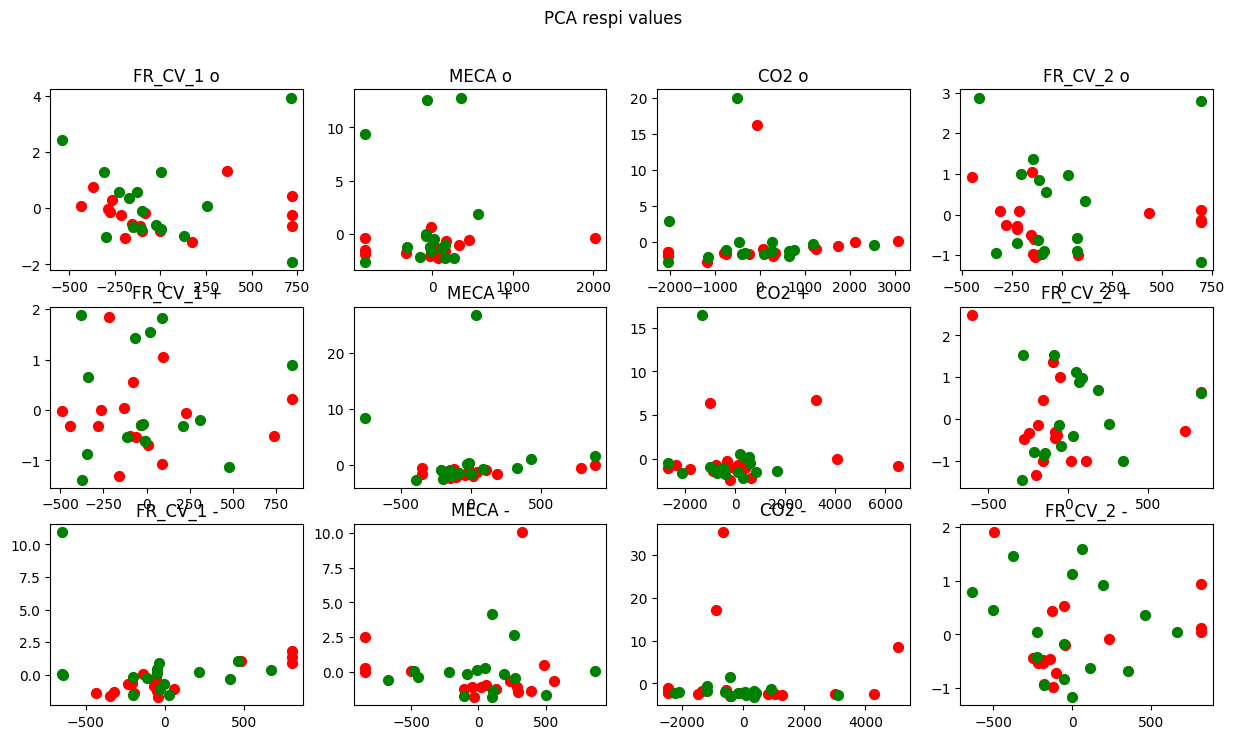

In [157]:
fig, axs = plt.subplots(ncols=len(conditions), nrows=len(odor_list))

for cond_i, cond in enumerate(conditions):

    for odor_i, odor in enumerate(odor_list):

        ax = axs[odor_i, cond_i]

        df_pca = df_allsujet.query(f"cond == '{cond}' and session == '{odor}'")
        X = df_pca[metric_list].values
        pca = PCA(n_components=2).fit_transform(X)
        df_pca_fit = pd.DataFrame(data = pca, columns = ['principal component 1', 'principal component 2'])

        ax.set_title(f"{cond} {odor}")
        targets = ['YES', 'NO']
        colors = ['r', 'g']
        for target, color in zip(targets,colors):
            indicesToKeep = df_pca['select_best'] == target
            ax.scatter(df_pca_fit.loc[indicesToKeep.values, 'principal component 1']
                    , df_pca_fit.loc[indicesToKeep.values, 'principal component 2'], c = color, s = 50)

plt.suptitle('PCA respi values')
fig.set_figheight(8)
fig.set_figwidth(15)

## 10s chunk

In [154]:
df_respi_chunk

,sujet,cond,session,inspi_duration,expi_duration,cycle_freq,total_amplitude
0,PD01,FR_CV_1,o,2.376565,5.363066,0.135983,0.044845
1,PD01,FR_CV_1,+,2.382823,3.533166,0.176825,0.074830
2,PD01,FR_CV_1,-,2.110252,3.091931,0.194036,0.062779
3,PD01,MECA,o,2.249814,2.838517,0.199156,0.039202
4,PD01,MECA,+,2.405626,2.406748,0.209356,0.102074
...,...,...,...,...,...,...,...
391,MA33,CO2,+,2.730258,2.548166,0.191156,873.623768
392,MA33,CO2,-,2.620709,2.718961,0.188115,738.833538
393,MA33,FR_CV_2,o,1.726414,2.036417,0.268783,593.360251
394,MA33,FR_CV_2,+,1.694549,1.776030,0.288589,726.409347


In [155]:
sujet_sel_mask = []

for row_i in range(df_respi_chunk.shape[0]):

    if df_respi_chunk['sujet'].iloc[row_i] in sujet_best:

        sujet_sel_mask.append('YES')

    else:

        sujet_sel_mask.append('NO')

df_respi_chunk['select_best'] = sujet_sel_mask
df_respi_chunk

,sujet,cond,session,inspi_duration,expi_duration,cycle_freq,total_amplitude,select_best
0,PD01,FR_CV_1,o,2.376565,5.363066,0.135983,0.044845,YES
1,PD01,FR_CV_1,+,2.382823,3.533166,0.176825,0.074830,YES
2,PD01,FR_CV_1,-,2.110252,3.091931,0.194036,0.062779,YES
3,PD01,MECA,o,2.249814,2.838517,0.199156,0.039202,YES
4,PD01,MECA,+,2.405626,2.406748,0.209356,0.102074,YES
...,...,...,...,...,...,...,...,...
391,MA33,CO2,+,2.730258,2.548166,0.191156,873.623768,YES
392,MA33,CO2,-,2.620709,2.718961,0.188115,738.833538,YES
393,MA33,FR_CV_2,o,1.726414,2.036417,0.268783,593.360251,YES
394,MA33,FR_CV_2,+,1.694549,1.776030,0.288589,726.409347,YES


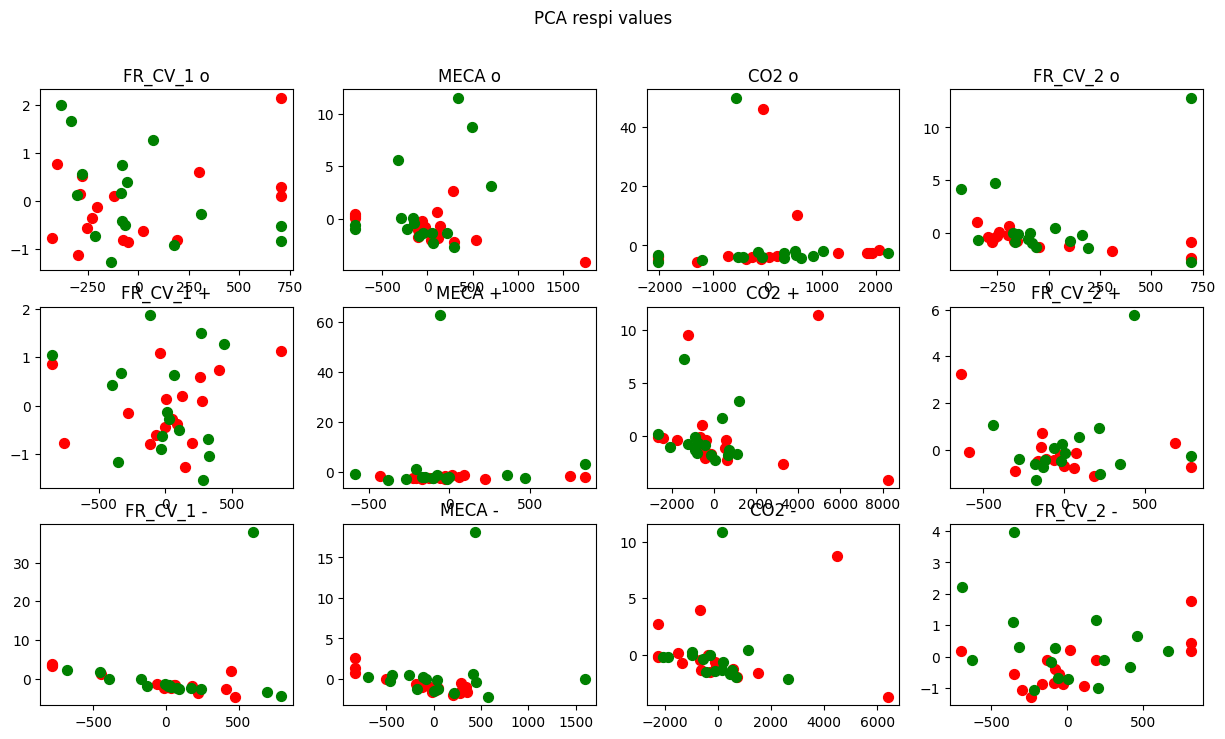

In [158]:
fig, axs = plt.subplots(ncols=len(conditions), nrows=len(odor_list))

for cond_i, cond in enumerate(conditions):

    for odor_i, odor in enumerate(odor_list):

        ax = axs[odor_i, cond_i]

        df_pca = df_respi_chunk.query(f"cond == '{cond}' and session == '{odor}'")
        X = df_pca[metric_list].values
        pca = PCA(n_components=2).fit_transform(X)
        df_pca_fit = pd.DataFrame(data = pca, columns = ['principal component 1', 'principal component 2'])

        ax.set_title(f"{cond} {odor}")
        targets = ['YES', 'NO']
        colors = ['r', 'g']
        for target, color in zip(targets,colors):
            indicesToKeep = df_pca['select_best'] == target
            ax.scatter(df_pca_fit.loc[indicesToKeep.values, 'principal component 1']
                    , df_pca_fit.loc[indicesToKeep.values, 'principal component 2'], c = color, s = 50)

plt.suptitle('PCA respi values')
fig.set_figheight(8)
fig.set_figwidth(15)